# 一、資料匯入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family']='SimHei' #顯示中文 (for Mac)
plt.rcParams['axes.unicode_minus']=False #正常顯示負號

pd.set_option("display.max_columns",50) #設定pandas最多顯示出50個欄位資訊
df_ml = pd.read_csv('tw_house.csv', encoding='big5') #台北市
df_ml.sample(5) #隨機取其中5筆資料

,鄉鎮市區,土地移轉總面積平方公尺,建物移轉總面積平方公尺,單價每平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,車位移轉總面積平方公尺,車位總價元,屋齡,建築完成年,交易年,總價元,中山區,中正區,信義區,內湖區,北投區,南港區,士林區,大同區,大安區,文山區,松山區,萬華區
269,大安區,14.78,78.55,315086,1,2,1,0.00,0,6,100,106,2475.0,0,0,0,0,0,0,0,0,1,0,0,0
59,內湖區,69.74,580.76,214022,0,0,0,309.76,15200000,1,105,105,7320.0,0,0,0,1,0,0,0,0,0,0,0,0
198,北投區,20.51,62.82,87552,2,1,1,0.00,0,17,89,106,550.0,0,0,0,0,1,0,0,0,0,0,0,0
159,北投區,13.59,65.99,60615,2,2,2,0.00,0,31,75,106,400.0,0,0,0,0,1,0,0,0,0,0,0,0
353,信義區,8.81,62.64,285441,2,2,2,0.00,0,12,94,106,1788.0,0,0,1,0,0,0,0,0,0,0,0,0


# 二、建模前預處理

## 切分訓練及測試資料

In [2]:
from sklearn.model_selection import train_test_split

X = df_ml[['建物移轉總面積平方公尺']]
y = df_ml[['總價元']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # 30% for testing, 70% for training
X_train.head()

,建物移轉總面積平方公尺
482,73.69
167,110.48
534,118.16
208,58.32
631,72.04


## 標準化

In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_std = sc.transform(X)

## 產生高次方項

In [4]:
from sklearn.preprocessing import PolynomialFeatures

quadratic = PolynomialFeatures(degree=2) #0~2次方

X_train_poly = quadratic.fit_transform(X_train_std)
X_test_poly = quadratic.fit_transform(X_test_std) 
X_poly = quadratic.fit_transform(X_std)

## plot_learning_curve function

In [5]:
# Scikit-Learn 官網作圖函式
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,6))  #調整作圖大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


# 三、KNNRegressor (assign k)

In [6]:
from sklearn.neighbors import KNeighborsRegressor

knnr = KNeighborsRegressor(n_neighbors=4,weights='uniform') # or weight='distance'
knnr.fit(X_train_std, y_train)

print("MSE: %.2f" % np.mean((knnr.predict(X_test_std) - y_test) ** 2))
print("R Square:",knnr.score(X_test_std, y_test))

MSE: 2915657.68
R Square: 0.455436917008582


## 畫決策邊界

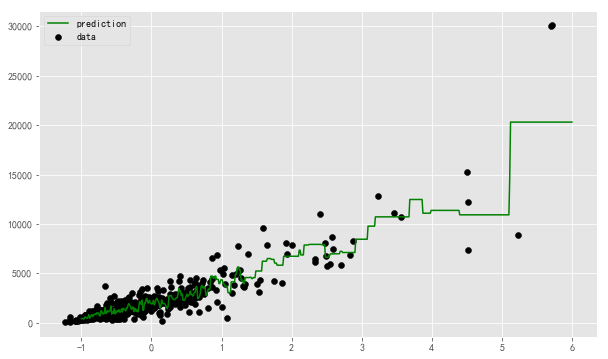

In [7]:
T = np.linspace(-1, 6, 600).reshape(-1,1) #reshape成二維矩陣

plt.figure(figsize=(10,6))
plt.scatter(X_train_std, y_train['總價元'], c='k', label='data')
plt.plot(T, knnr.predict(T), c='g', label='prediction')
plt.legend()
plt.show()

## 校調k值

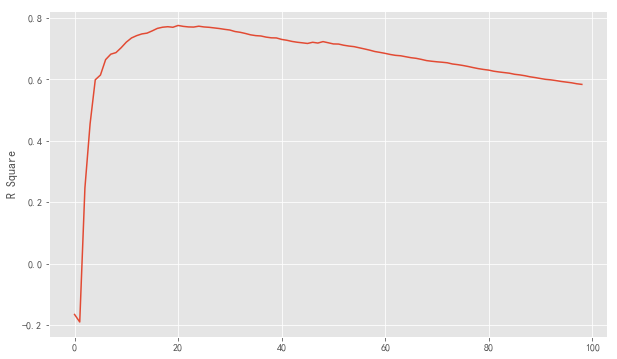

In [8]:
score_list=[]
for i in range(1,100):
    knnr = KNeighborsRegressor(n_neighbors=i)
    knnr.fit(X_train_std, y_train)
    score_list.append(knnr.score(X_test_std, y_test))
plt.figure(figsize=(10,6))
plt.ylabel('R Square')
plt.plot(score_list)

# 四、SVM Regressor

In [9]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train_std, y_train.values.ravel()) #ravel()壓縮成一維矩陣

print("MSE: %.2f" % np.mean((svr.predict(X_test_std) - y_test.values.ravel()) ** 2))
print("R Square:",svr.score(X_test_std, y_test.values.ravel()))

MSE: 5781168.27
R Square: -0.07976009531911621


## 三種kernel比較(可tune C、degree)

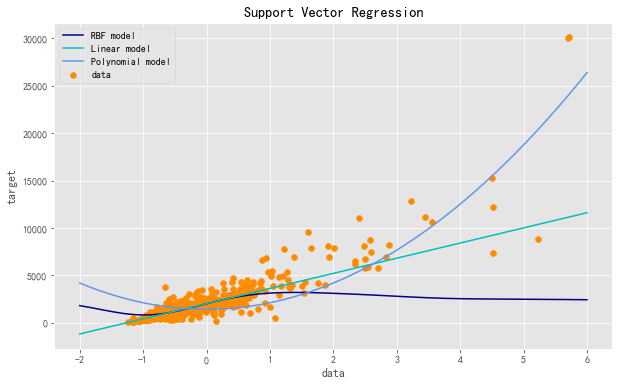

In [10]:
T = np.linspace(-2, 6, 600).reshape(-1,1) #reshape成二維矩陣

svr_rbf = SVR(kernel='rbf', C=30)
svr_lin = SVR(kernel='linear', C=30)
svr_poly = SVR(kernel='poly', C=30, degree=2)

y_rbf = svr_rbf.fit(X_train_std, y_train.values.ravel()).predict(T)
y_linear = svr_lin.fit(X_train_std, y_train.values.ravel()).predict(T)
y_poly = svr_poly.fit(X_train_std, y_train.values.ravel()).predict(T)

plt.figure(figsize=(10,6))
plt.scatter(X_train_std, y_train['總價元'], color='darkorange', label='data')
plt.plot(T, y_rbf, color='navy', label='RBF model')
plt.plot(T, y_linear, color='c', label='Linear model')
plt.plot(T, y_poly, color='cornflowerblue', label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

# 六、迴歸樹
可調max_depth

In [11]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X_train_std, y_train)

print("MSE: %.2f" % np.mean((dtr.predict(X_test_std) - y_test.values.ravel()) ** 2)) #.values.ravel()把矩陣轉成一維
print("R Square:",dtr.score(X_test_std, y_test))

MSE: 5896492.55
R Square: -0.10129943616587589


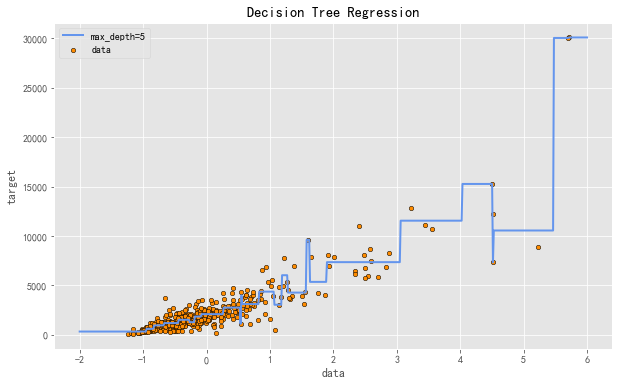

In [12]:
T = np.linspace(-2, 6, 600).reshape(-1,1) #reshape成二維矩陣

plt.figure(figsize=(10,6))
plt.scatter(X_train_std, y_train['總價元'], s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(T, dtr.predict(T), color="cornflowerblue", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [13]:
type(y_train['總價元'])

pandas.core.series.Series

### it's your turn...
#### try KFold、使用更多特徵、校調超參數值...etc